In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9
import pickle


from statsmodels.stats.multitest import fdrcorrection
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import TheilSenRegressor

from scipy.stats import spearmanr as sp_spearmanr
from scipy.stats import pearsonr as sp_pearsonr
import scipy.io as sci_io

from brainsmash.mapgen.base import Base
from brainsmash.mapgen.stats import spearmanr as bs_spearmanr
from brainsmash.mapgen.stats import pearsonr as bs_pearsonr
from scipy.stats import kstest as sp_kstest

#  1. Structure gradient
* diff pro
* layer marker
* synaptome

In [4]:
expr = pd.read_csv("../data/2.prodata/protomics_expr_processed.tsv", sep="\t", index_col=0)
expr_scale = pd.DataFrame(preprocessing.scale(expr, axis=1), index=expr.index, columns=expr.columns)

In [5]:
dist = sci_io.loadmat("../data/0.rawdata/from_cl/INSsam_eud.mat")['eud']

In [6]:
group = "INS "+pd.Series(expr_scale.columns).str.split("-", expand=True)[0].values

In [7]:
gradient = pd.read_csv("../data/0.rawdata/from_cl/insula_gredient.tsv", sep="\t", index_col=0, header=None).values
sample_gradient = gradient[:15].reshape((15, ))
region_gradient = gradient[15:].reshape((4, ))
sample_gradient, region_gradient

(array([0.01408533, 0.00940217, 0.09424626, 0.62303919, 0.63558471,
        0.75779951, 0.82817811, 0.78731966, 0.88464737, 0.88901967,
        0.93349958, 0.93518335, 0.96009874, 0.96331143, 0.97923142]),
 array([0.1852, 0.7522, 0.9106, 0.9675]))

In [ ]:
n_perm = 10000
gen = Base(x=sample_gradient, D=dist)
surrogate_maps = gen(n=n_perm)

In [11]:
n_perm = 10000
#pickle.dump(surrogate_maps, open("../res/3.surro_maps_structure.pkl", 'wb'))
surrogate_maps = pickle.load(open("../res/3.surro_maps_structure.pkl", 'rb'))

## 1.1 diff pro

In [9]:
diff_pro_genelist = pd.read_csv("../data/2.prodata/combined_genelist.txt", header=None)[0]
diff_pro_expr = expr_scale.loc[diff_pro_genelist, ]

In [10]:
diff_pro_PC1 = PCA(n_components=1, svd_solver="full").fit_transform(diff_pro_expr.T).flatten()
rho, _ = sp_spearmanr(sample_gradient, diff_pro_PC1)
surrogate_rho = bs_spearmanr(diff_pro_PC1, surrogate_maps)
pval = (1+(surrogate_rho > rho).sum())/(1+n_perm)
rho, pval

(0.6928571428571427, 0.0047995200479952005)

In [11]:
TheilSen_obj = TheilSenRegressor().fit(sample_gradient.reshape((-1, 1)), preprocessing.minmax_scale(diff_pro_PC1))

In [12]:
TheilSen_obj.coef_, TheilSen_obj.intercept_

(array([0.6287611]), -0.23977714265675273)

In [13]:
diff_pro_dat = pd.DataFrame([sample_gradient, preprocessing.minmax_scale(diff_pro_PC1)], index=['x', 'y']).T
diff_pro_dat['group'] = group

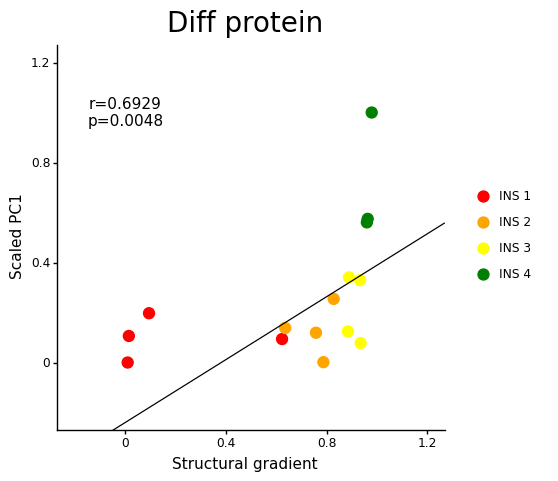

<ggplot: (8762017053718)>

In [15]:
diff_pro_plot = ( p9.ggplot(p9.aes(x="x", y="y", color="group"), diff_pro_dat)
  + p9.geom_point(size=4)
  + p9.geom_abline(slope=TheilSen_obj.coef_, intercept=TheilSen_obj.intercept_, color="black")
  #+ p9.geom_text(p9.aes(x=[0], y=[1], label=[f"r={rho:.4f}\np={pval:.4f}"]), color="black")
  + p9.annotate("text", x=0, y=1, label=f"r={rho:.4f}\np={pval:.4f}", color="black")
  + p9.scale_color_manual(values=["red", "orange", "yellow", "green"])
  + p9.theme_classic()
  + p9.xlab("Structural gradient") + p9.ylab("Scaled PC1") + p9.ggtitle("Diff protein")
  + p9.xlim(-0.2, 1.2) + p9.ylim(-0.2, 1.2)
  + p9.theme(axis_text=p9.element_text(color="black"),
             plot_title=p9.element_text(color="black", size=20),
             legend_title=p9.element_blank(),
             figure_size=(5, 5)
             )
)
p9.ggsave(diff_pro_plot, "../res/diff_pro_corr.pdf", verbose=False)
diff_pro_plot

## 1.2 layer marker

In [55]:
layer_marker_filename = "../data/0.rawdata/from_papers/neuron_11047_mmc6.xlsx"
layer_marker = [pd.read_excel(layer_marker_filename, sheet_name=f"Layer{i}enriched")["Gene Symbol"].dropna().unique() for i in range(2, 7) ]

In [60]:
layer_dat_point = []
layer_dat_anno = []

for i, genelist in enumerate(layer_marker):
    idx = pd.Series(expr_scale.index).str.split('|', expand=True)[1].isin(genelist)
    layer_expr = expr_scale.values[idx, :]
    #layer_expr_PC1 = np.mean(layer_expr, axis=0).flatten()
    layer_expr_PC1 = PCA(n_components=1, svd_solver="full").fit_transform(layer_expr.T).flatten()
    
    layer_rho, _ = sp_spearmanr(sample_gradient, layer_expr_PC1)
    surrogate_rho = bs_spearmanr(surrogate_maps, layer_expr_PC1)
    pval = (1+(surrogate_rho > layer_rho).sum())/(1+n_perm)
    print(layer_rho, pval)

    layer_expr_PC1_scale = preprocessing.minmax_scale(layer_expr_PC1)
    layer_TheilSen_obj = TheilSenRegressor().fit(sample_gradient.reshape((-1, 1)), layer_expr_PC1_scale)

    tmp_dat = pd.DataFrame([sample_gradient, layer_expr_PC1_scale], index=['x', 'y']).T
    tmp_dat['Group'] = group
    tmp_dat['Layer'] = f"Layer{i+2}"
    layer_dat_point.append(tmp_dat)

    layer_dat_anno.append([layer_TheilSen_obj.coef_[0], layer_TheilSen_obj.intercept_, f"Layer{i+2}", str(round(layer_rho, 4)), pval])

layer_dat_point = pd.concat(layer_dat_point)
layer_dat_anno = pd.DataFrame(layer_dat_anno, columns=['slope', 'intercept', "Layer", 'rho', "pval"])
layer_dat_anno['FDR'] = fdrcorrection(layer_dat_anno['pval'], method="indep", is_sorted=False)[1]
layer_dat_anno["Labels"] = "r="+layer_dat_anno['rho']+"\nFDR="+pd.Series([str(i) for i in np.round(layer_dat_anno['FDR'], 4)])


0.2964285714285714 0.148985101489851
0.6428571428571428 0.010998900109989001
0.6142857142857142 0.0108989101089891
-0.06785714285714285 0.6135386461353864
0.4928571428571427 0.0367963203679632


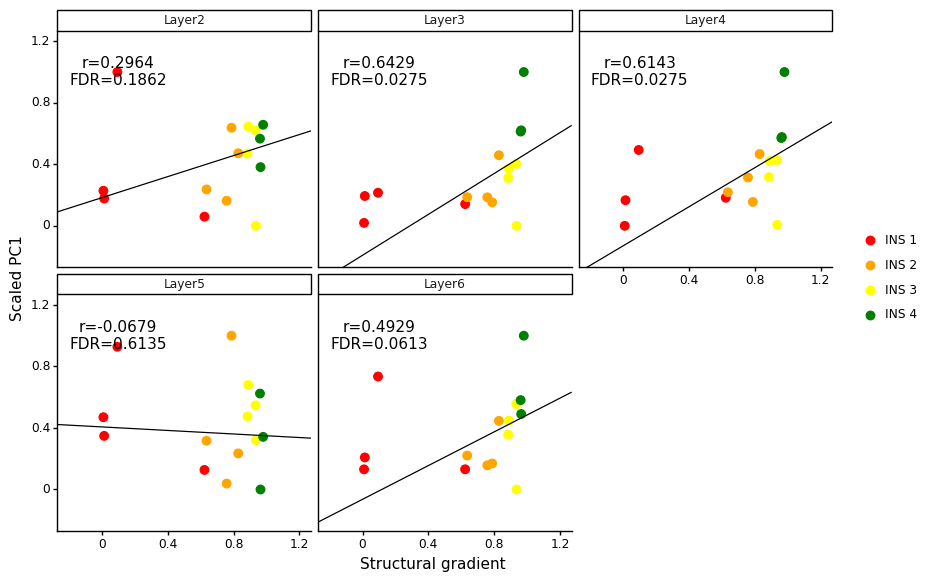

<ggplot: (8788694312400)>

In [61]:
layer_plot = ( p9.ggplot(p9.aes(x="x", y="y", color="Group"), layer_dat_point)
  + p9.geom_point(size=3)
  + p9.geom_abline(p9.aes(slope="slope", intercept="intercept"), layer_dat_anno)
  + p9.geom_text(p9.aes(x=0.1, y=1, label="Labels"), layer_dat_anno, color="black")
  + p9.scale_color_manual(values=["red", "orange", "yellow", "green"])
  + p9.theme_classic()
  + p9.xlab("Structural gradient") + p9.ylab("Scaled PC1")
  + p9.xlim(-0.2, 1.2) + p9.ylim(-0.2, 1.2)
  + p9.facet_wrap("~Layer", nrow=2, ncol=3)
  + p9.theme(axis_text=p9.element_text(color="black"),
             plot_title=p9.element_text(color="black", size=20),
             legend_title=p9.element_blank(),
             figure_size=(10, 6.5)
             )
  
)

p9.ggsave(layer_plot, "../res/layer_marker_corr.pdf", units="in", verbose=False)
layer_plot


## 1.3 Synaptome

In [9]:
synaptome_genelist = pd.read_excel("../data/0.rawdata/from_papers/41593_2018_195_MOESM4_ESM.xlsx", sheet_name="Synaptome", header=None).values.flatten()
synaptome_idx = pd.Series(expr_scale.index).str.split('|', expand=True)[1].isin(synaptome_genelist)
synaptome_expr = expr_scale.values[synaptome_idx, :]

In [12]:
synaptome_expr_PC1 = PCA(n_components=1, svd_solver="full").fit_transform(synaptome_expr.T).flatten()

synaptome_rho, _ = sp_spearmanr(sample_gradient, synaptome_expr_PC1)
surrogate_rho = bs_spearmanr(surrogate_maps, synaptome_expr_PC1)
pval = (1+(surrogate_rho > synaptome_rho).sum())/(1+n_perm)
print(synaptome_rho, pval)

synaptome_expr_PC1_scale = preprocessing.minmax_scale(synaptome_expr_PC1)
synaptome_TheilSen_obj = TheilSenRegressor().fit(sample_gradient.reshape((-1, 1)), synaptome_expr_PC1_scale)

0.6285714285714286 0.0115988401159884


In [13]:
synaptome_dat = pd.DataFrame([sample_gradient, synaptome_expr_PC1_scale], index=['x', 'y']).T
synaptome_dat['group'] = group

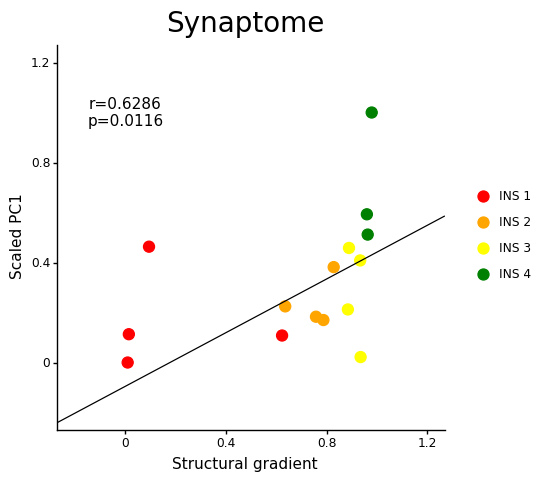

<ggplot: (8761991512260)>

In [22]:
synaptome_plot = ( p9.ggplot(p9.aes(x="x", y="y", color="group"), synaptome_dat)
  + p9.geom_point(size=4)
  + p9.geom_abline(slope=synaptome_TheilSen_obj.coef_, intercept=synaptome_TheilSen_obj.intercept_, color="black")
  #+ p9.geom_text(p9.aes(x=[0], y=[1], label=[f"r={rho:.4f}\np={pval:.4f}"]), color="black")
  + p9.annotate("text", x=0, y=1, label=f"r={synaptome_rho:.4f}\np={pval:.4f}", color="black")
  + p9.scale_color_manual(values=["red", "orange", "yellow", "green"])
  + p9.theme_classic()
  + p9.xlab("Structural gradient") + p9.ylab("Scaled PC1") + p9.ggtitle("Synaptome")
  + p9.xlim(-0.2, 1.2) + p9.ylim(-0.2, 1.2)
  + p9.theme(axis_text=p9.element_text(color="black"),
             plot_title=p9.element_text(color="black", size=20),
             legend_title=p9.element_blank(),
             figure_size=(5, 5)
             )
)
p9.ggsave(synaptome_plot, "../res/synaptome_corr.pdf", verbose=False)
synaptome_plot

## 1.3.2 subtype

In [20]:
NMDA_receptor = ["GRIN1", "GRIN2A", "GRIN2B", "GRIN2C", "GRIN2D", "GRIN3A", "GRIN3B", "GRINA"]
GABA_receptor = ["GABRA1", "GABRA2", "GABRA3", "GABRA4", "GABRA5"]
Dopa_receptor = ["DRD1", "DRD2", "DRD3", "DRD4", "DRD5",]
Sero_receptor = ["HTR1A", "HTR1E", "HTR1F", "HTR2A", "HTR2C", "HTR3B", "HTR4", "HTR5A", "HTR7"]

In [62]:
receptor_type = ["NMDA", "GABA", "Dopamine", "Serotonin(5-HT)"]

receptor_dat_point = []
receptor_dat_anno = []

for i, genelist in enumerate([NMDA_receptor, GABA_receptor, Dopa_receptor, Sero_receptor]):
    idx = pd.Series(expr_scale.index).str.split('|', expand=True)[1].isin(genelist)
    receptor_expr = expr_scale.values[idx, :]
    #print(receptor_expr.shape)
    if receptor_expr.shape[0] == 1:
        receptor_expr_PC1 = receptor_expr.flatten()
    else:
        receptor_expr_PC1 = np.mean(receptor_expr, axis=0).flatten()
        #receptor_expr_PC1 = receptor_expr[1, :].flatten()
        #receptor_expr_PC1 = PCA(n_components=1, svd_solver="full").fit_transform(receptor_expr.T).flatten()
    print(receptor_expr_PC1)

    receptor_rho, _ = sp_spearmanr(sample_gradient, receptor_expr_PC1)
    surrogate_rho = bs_spearmanr(surrogate_maps, receptor_expr_PC1)
    pval = (1+(surrogate_rho > receptor_rho).sum())/(1+n_perm)
    print(receptor_rho, pval)

    receptor_expr_PC1_scale = preprocessing.minmax_scale(receptor_expr_PC1)
    receptor_TheilSen_obj = TheilSenRegressor().fit(sample_gradient.reshape((-1, 1)), receptor_expr_PC1_scale)

    tmp_dat = pd.DataFrame([sample_gradient, receptor_expr_PC1_scale], index=['x', 'y']).T
    tmp_dat['Group'] = group
    tmp_dat['Type'] = receptor_type[i]
    receptor_dat_point.append(tmp_dat)

    receptor_dat_anno.append([receptor_TheilSen_obj.coef_[0], receptor_TheilSen_obj.intercept_, receptor_type[i], str(round(receptor_rho, 4)), pval])

receptor_dat_point = pd.concat(receptor_dat_point)
receptor_dat_point["Type"] = pd.Categorical(receptor_dat_point["Type"], categories=receptor_type)

receptor_dat_anno = pd.DataFrame(receptor_dat_anno, columns=['slope', 'intercept', "Type", 'rho', "pval"])
receptor_dat_anno['FDR'] = fdrcorrection(receptor_dat_anno['pval'], method="indep", is_sorted=False)[1]
receptor_dat_anno["Labels"] = "r="+receptor_dat_anno['rho']+"\nFDR="+pd.Series([str(i) for i in np.round(receptor_dat_anno['FDR'], 4)])
receptor_dat_anno["Type"] = pd.Categorical(receptor_dat_anno["Type"], categories=receptor_type)


[ 2.27940982e-01  3.11411128e-01 -1.23448693e+00  6.81916774e-01
  4.12760781e-01  5.72441558e-01 -9.45821339e-02  6.15723118e-01
  6.95973427e-04  3.97168877e-01 -2.45899236e-01  2.06625109e-01
 -7.50820889e-03 -1.00719778e+00 -8.37010009e-01]
-0.46071428571428563 0.9342065793420657
[ 0.89004451  0.4226646  -0.64475812 -0.09805552 -0.22339362  0.2138453
  0.32986658  0.00664711 -0.08795562 -0.30942773 -0.45966795  0.64029707
 -0.06915253 -0.16375245 -0.44720162]
-0.28928571428571426 0.8747125287471252
[-1.20371324 -0.34922964 -0.49545797 -0.16749572 -0.55157656 -0.03099168
 -0.04464185 -0.49046546  0.64207424 -0.46688857 -0.14527295 -0.24447131
 -0.23155309  0.35685513  3.42282867]
0.6142857142857142 0.008799120087991202
[ 1.18657835  0.15923384 -1.69137773  0.63096569  0.11498516  0.3269848
  0.3994142  -1.22341288  0.44079829 -0.79588782 -0.96815243  2.16899606
  0.00880646  0.56296741 -1.32089941]
-0.10714285714285714 0.6527347265273473


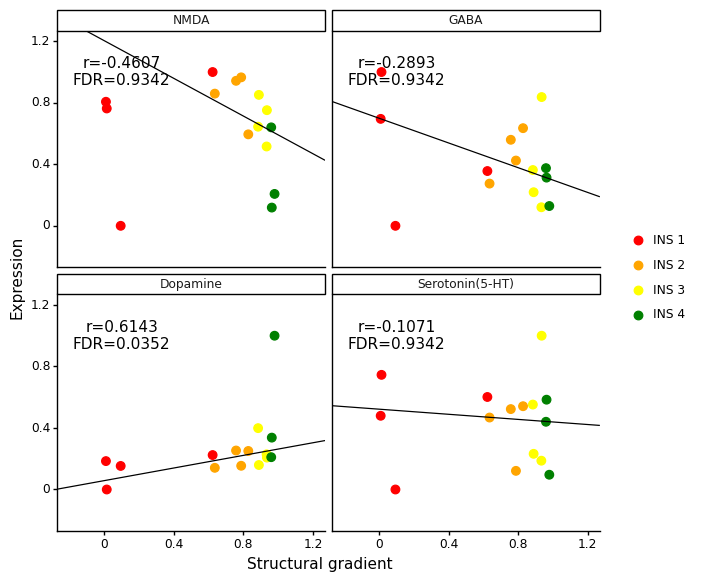

<ggplot: (8788672209746)>

In [49]:
receptor_plot = ( p9.ggplot(p9.aes(x="x", y="y", color="Group"), receptor_dat_point)
  + p9.geom_point(size=3)
  + p9.geom_abline(p9.aes(slope="slope", intercept="intercept"), receptor_dat_anno)
  + p9.geom_text(p9.aes(x=0.1, y=1, label="Labels"), receptor_dat_anno, color="black")
  + p9.scale_color_manual(values=["red", "orange", "yellow", "green"])
  + p9.theme_classic()
  + p9.xlab("Structural gradient") + p9.ylab("Expression")
  + p9.xlim(-0.2, 1.2) + p9.ylim(-0.2, 1.2)
  + p9.facet_wrap("~Type", nrow=2, ncol=2)
  + p9.theme(axis_text=p9.element_text(color="black"),
             plot_title=p9.element_text(color="black", size=20),
             legend_title=p9.element_blank(),
             figure_size=(7, 6.5)
             )
  
)

#p9.ggsave(receptor_plot, "../res/receptor_marker_corr.pdf", units="in", verbose=False)
receptor_plot

# 2. Compare with other gradient
* structural 
* T1/T2 ratio
* thickness

In [2]:
# load gradient
structral_gradient = pd.read_csv("../data/0.rawdata/from_cl/insula_gredient.tsv", sep="\t", index_col=0, header=None).values[:15].flatten()
thickness_gradient = np.delete(sci_io.loadmat("../data/0.rawdata/from_cl/INS_thickness_myelin.mat")['INSthickness'].flatten(), 1)
myelin_gradient = pd.read_excel("../data/0.rawdata/from_cl/INSsam_myelin.xlsx", header=None).values.flatten()
structral_gradient.shape, thickness_gradient.shape, myelin_gradient.shape

((15,), (14,), (15,))

In [3]:
# gradient scale: unit vector
all_gradients_scale = [ preprocessing.normalize(gred.reshape(-1, 1), norm="l2", axis=0) for gred in [structral_gradient,  myelin_gradient, thickness_gradient] ]

In [4]:
# load protein expr of different gene set
## 1. total expr
expr = pd.read_csv("../data/2.prodata/protomics_expr_processed.tsv", sep="\t", index_col=0)
expr_scale = pd.DataFrame(preprocessing.scale(expr, axis=1), index=expr.index, columns=expr.columns)

## 2. diff expr
diff_pro_genelist = pd.read_csv("../data/2.prodata/combined_genelist.txt", header=None)[0]
diff_pro_expr = expr_scale.loc[diff_pro_genelist, ]

## 3. layer marker
layer_marker_filename = "../data/0.rawdata/from_papers/neuron_11047_mmc6.xlsx"
layer_marker = np.unique(np.concatenate([pd.read_excel(layer_marker_filename, sheet_name=f"Layer{i}enriched")["Gene Symbol"].dropna().unique() for i in [3, 4] ]))
idx = pd.Series(expr_scale.index).str.split('|', expand=True)[1].isin(layer_marker)
layer_expr = expr_scale.values[idx, :]

## 4. synaptome
synaptome_genelist = pd.read_excel("../data/0.rawdata/from_papers/41593_2018_195_MOESM4_ESM.xlsx", sheet_name="Synaptome", header=None).values.flatten()
synaptome_idx = pd.Series(expr_scale.index).str.split('|', expand=True)[1].isin(synaptome_genelist)
synaptome_expr = expr_scale.values[synaptome_idx, :]

expr_scale.shape, diff_pro_expr.shape, layer_expr.shape, synaptome_expr.shape

((6090, 15), (801, 15), (68, 15), (1669, 15))

In [5]:
def calc_explained_variance(gred_norm, cov):
    return np.dot(gred_norm.T, cov).dot(gred_norm)

gene_set_label = ["All", "Diff", "Layer marker", "Synaptome"]
compare_res_var = []
compare_res_corr = []
for i, gene_set_expr in enumerate([expr_scale, diff_pro_expr, layer_expr, synaptome_expr]):
    gene_set_expr= np.array(gene_set_expr)
    pca_obj_15sample = PCA(n_components=1).fit(gene_set_expr.T)
    pca_obj_14sample = PCA(n_components=1).fit(np.delete(gene_set_expr, 1, axis=1).T)

    comp1_15sample = pca_obj_15sample.fit_transform(gene_set_expr.T)
    comp1_14sample = pca_obj_14sample.fit_transform(np.delete(gene_set_expr, 1, axis=1).T)

    comp1_15sample_norm = preprocessing.normalize(comp1_15sample, norm="l2", axis=0)
    comp1_14sample_norm = preprocessing.normalize(comp1_14sample, norm="l2", axis=0)

    cov_15sample = np.cov(gene_set_expr.T)
    cov_14sample= np.cov(np.delete(gene_set_expr, 1, axis=1).T)

    compare_res_var.append([ calc_explained_variance(comp1_15sample_norm, cov_15sample)[0, 0],
                             calc_explained_variance(comp1_14sample_norm, cov_14sample)[0, 0],
                             calc_explained_variance(all_gradients_scale[0], cov_15sample)[0, 0], 
                             calc_explained_variance(all_gradients_scale[1], cov_15sample)[0, 0],
                             calc_explained_variance(all_gradients_scale[2], cov_14sample)[0, 0], gene_set_label[i] ])
    
    #break

In [6]:
pd.DataFrame(compare_res_var)

,0,1,2,3,4,5
0,4.471872,4.034209,0.343572,0.039632,0.107680,All
1,8.993035,8.275460,0.537359,0.050432,0.051985,Diff
2,4.047487,3.684420,0.324423,0.032514,0.093797,Layer marker
3,4.947103,4.418299,0.352479,0.043130,0.089154,Synaptome


In [11]:
# bootstrap sampling
boot_vars = []
n_boot = 1000
for i, gene_set_expr in enumerate([expr_scale, diff_pro_expr, layer_expr, synaptome_expr]):
    tmp = np.empty(shape=(n_boot, 5))
    
    n_genes = gene_set_expr.shape[0]
    for k in range(n_boot):
        resampled_idx = np.random.choice(range(n_genes), size=n_genes, replace=True)
        resampled_expr = np.array(gene_set_expr)[resampled_idx, :]

        resampled_cov_15sample = np.cov(resampled_expr.T)
        resampled_cov_14sample = np.cov(np.delete(resampled_expr, 1, axis=1).T)

        resampled_pc1_15sample = preprocessing.normalize( PCA(n_components=1).fit_transform(resampled_expr.T), norm="l2", axis=0)
        resampled_pc1_14sample = preprocessing.normalize( PCA(n_components=1).fit_transform(np.delete(resampled_expr, 1, axis=1).T), norm="l2", axis=0)

        tmp[k, :] = [ calc_explained_variance(resampled_pc1_15sample, resampled_cov_15sample)[0, 0],
                      calc_explained_variance(resampled_pc1_14sample, resampled_cov_14sample)[0, 0],
                      calc_explained_variance(all_gradients_scale[0], resampled_cov_15sample)[0, 0],
                      calc_explained_variance(all_gradients_scale[1], resampled_cov_15sample)[0, 0],
                      calc_explained_variance(all_gradients_scale[2], resampled_cov_14sample)[0, 0], ]
    boot_vars.append(tmp)
    #break

In [9]:
#pickle.dump(boot_vars, open("../res/3.bootstrap_variance.pkl","wb"))
#boot_vars = pickle.load(open("../res/3.bootstrap_variance.pkl","rb"))

In [12]:
compare_dat = pd.DataFrame(compare_res_var, columns=["1", "2", "Structure", "Myelin", "Thickness", "Gene_sets"]).iloc[:, 2:]
compare_std = np.array(boot_vars).std(axis=1)[:, 2:]
upper_line = compare_dat.iloc[:, :3] + compare_std
upper_line["Gene_sets"] = compare_dat["Gene_sets"]
lower_line = compare_dat.iloc[:, :3] - compare_std
lower_line["Gene_sets"] = compare_dat["Gene_sets"]

compare_dat = compare_dat.melt(id_vars=["Gene_sets"], var_name="Gradient", value_name="Value")
compare_dat["Gradient"] = pd.Categorical(compare_dat["Gradient"], categories=["Structure", "Myelin", "Thickness"])
upper_line = upper_line.melt(id_vars=["Gene_sets"], var_name="Gradient", value_name="Upper")
lower_line = lower_line.melt(id_vars=["Gene_sets"], var_name="Gradient", value_name="Lower")
compare_errbar = pd.merge(upper_line, lower_line, how="left")
compare_errbar["Gradient"] = pd.Categorical(compare_errbar["Gradient"], categories=["Structure", "Myelin", "Thickness"])
compare_errbar["Value"] = compare_dat['Value']

In [13]:
step = 0.1
seg_line = pd.DataFrame()
seg_line["Gene_sets"] = ["All", "Diff", "Layer marker", "Synaptome"]
seg_line["y1"] = compare_errbar["Upper"].groupby(compare_errbar["Gene_sets"]).max().values * 1.05
seg_line["y2"] = seg_line["y1"] + step
seg_line["y3"] = seg_line["y2"] + step
seg_line["Gradient"] = "Structure"

In [14]:
txt_dat = pd.DataFrame()
txt_dat["Gene_sets"] = ["All", "Diff", "Layer marker", "Synaptome"]
txt_dat["Gradient"] = "Structure"
txt_dat["Label"] = "P<2.2e-16"
txt_dat["y1"] = seg_line["y1"] + step/2
txt_dat["y2"] = seg_line["y2"] + step/2

In [15]:
seg_line2 = seg_line.copy()
seg_line2["Gradient"] = "Myelin"

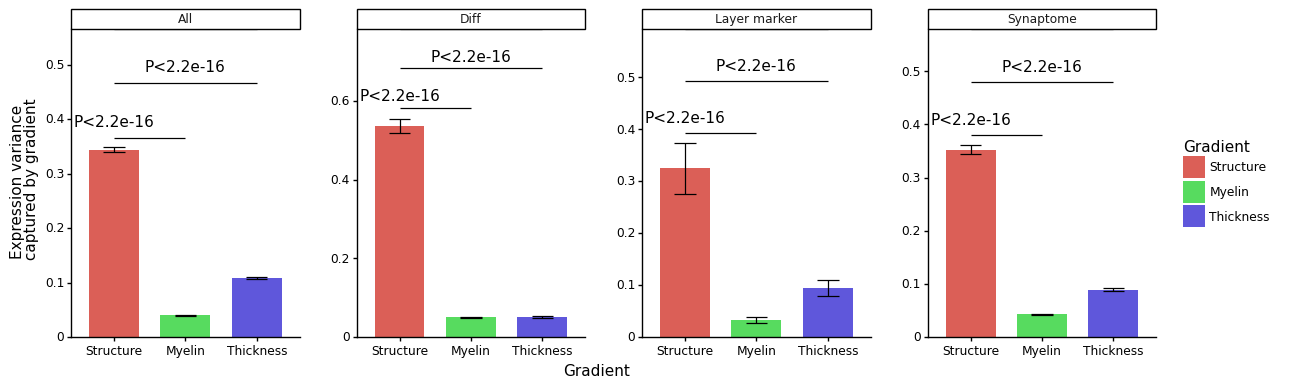

<ggplot: (8793837707261)>

In [16]:
compare_plot = (
    p9.ggplot(p9.aes(x="Gradient", y="Value", fill="Gradient"), compare_dat)
    + p9.geom_bar(stat="identity", width=0.7)
    + p9.geom_errorbar(p9.aes(ymin="Lower", ymax="Upper"), compare_errbar, width=0.3)
    #+ p9.geom_segment(p9.aes(x=0, y="Upper+0.2", xend=1, yend="Upper+0.2"), seg_line)
    + p9.geom_segment(p9.aes(x="Gradient", xend=2, y="y1", yend="y1"), seg_line)
    + p9.geom_segment(p9.aes(x="Gradient", xend=3, y="y2", yend="y2"), seg_line)
    + p9.geom_segment(p9.aes(x="Gradient", xend=3, y="y3", yend="y3"), seg_line)
    + p9.geom_text(p9.aes(x="Gradient", y="y1+0.03", label=txt_dat["Label"]), seg_line)
    + p9.geom_text(p9.aes(x="Gradient", y="y2+0.03", label=txt_dat["Label"]), seg_line2)
    + p9.theme_classic()
    + p9.ylab("Expression variance\n captured by gradient")
    + p9.scale_y_continuous(expand = (0, 0))
    + p9.theme(figure_size=(14, 4),
               axis_text=p9.element_text(color="black"),
               subplots_adjust={'wspace': 0.25}
               )
    + p9.guides(fill=p9.guide_legend(order=0))
    + p9.facet_wrap("~Gene_sets", nrow=1, ncol=4, scales="free_y")
)
p9.ggsave(compare_plot, "../res/compare_gradient.pdf", verbose=False)
compare_plot

In [4]:
# load distance matrix
dist = sci_io.loadmat("../data/0.rawdata/from_cl/INSsam_eud.mat")['eud']
dist2 = np.delete(np.delete(dist, 1, axis=0), 1, axis=1)

In [5]:
def calc_pval(surro_map, gred, rho):
    surro_map_rho = bs_spearmanr(surro_map, gred)
    return (1+(surro_map_rho>rho).sum())/(1+len(surro_map))

# generate surrogate map
n_perm = 10000
surro_map_struct = Base(x=structral_gradient, D=dist)(n=n_perm)
surro_map_thickness = Base(x=thickness_gradient, D=dist2)(n_perm)
surro_map_myelin = Base(x=myelin_gradient, D=dist)(n=n_perm)

In [6]:
#pickle.dump([surro_map_struct, surro_map_myelin, surro_map_thickness], open("../res/3.surro_maps_all.pkl", "wb") )
surro_map_struct, surro_map_myelin, surro_map_thickness = pickle.load(open("../res/3.surro_maps_all.pkl", "rb"))